In [227]:
import numpy
from etrade.spot.trader import Station
from etrade.spot.market.recycle import BasicRecycle, PointwiseRecycle
from etrade.spot.forecast.market import DistributiveSeries, DistributiveMarket
from etrade.spot.forecast.plan_a.constructor import *
from etrade.spot.forecast.plan_a.transformer import MarketSampleTransformer
from etrade.spot.forecast.yieldindex import zero_quantile
from etrade.spot.forecast import yieldindex
from  data_utils.stochastic_utils.vdistributions.abstract import AbstractDistribution
from  data_utils.stochastic_utils.vdistributions.parameter.continuous.basic import NormalDistribution, SkewNormalDistribution
from data_utils.stochastic_utils.vdistributions.nonparametric.continuous.kernel2 import KernelMixDistribution
from data_utils.stochastic_utils.vdistributions.tools.divergence import kl_divergence_continuous, crps, quantile_RMSE

from data_utils.stochastic_utils.vdistributions.nonparametric.continuous.mfk.skewnd2 import dof_snd_fitter

from scipy.optimize import differential_evolution

from matplotlib import pyplot
import json

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [228]:

with open(r"..\forecast\plan_a\data\market_simulator_3.json", "r") as f:
    train_data = json.loads(f.read())
    
with open(r"..\forecast\plan_a\data\market_simulator_4.json", "r") as f:
    test_data = json.loads(f.read())

In [229]:
train_data =numpy.asarray(train_data["data"])
test_data =numpy.asarray(test_data["data"])

In [230]:
market_len = 1
l = 3 * market_len + market_len * (20-0) * 3
def zscore_p(x):
    x = numpy.asarray(x)
    m = numpy.mean(x, axis=0)
    s = numpy.std(x, ddof=1, axis=0)
    return m,s

def zscore(x, m, s):
    x = numpy.asarray(x)
    m = numpy.asarray(m)
    s = numpy.asarray(s)
    return numpy.column_stack((
            (x[:,:l]-m[:l]) / s[:l], x[:,l]
    ))

def minmax_p(x):
    x = numpy.asarray(x)
    mmax = numpy.max(x, axis=0)
    mmin = numpy.min(x, axis=0)
    return mmin, mmax

def minmax(x, mmin, mmax):
    x = numpy.asarray(x)
    mmin = numpy.asarray(mmin)
    mmax = numpy.asarray(mmax)
    # return (x-mmin) / (mmax-mmin)
    return numpy.column_stack((
            (x[:,:l]-mmin[:l]) / (mmax[:l]-mmin[:l]), x[:,l]
    ))
    
    
    

In [231]:
m,s= zscore_p(train_data)
zscored_t = zscore(train_data, m, s)
zscored_x = zscore(test_data, m, s)

mmin,mmax = minmax_p(train_data)
minmaxed_t = minmax(train_data, mmin, mmax)
minmaxed_x = minmax(test_data, mmin, mmax)

In [232]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
# p = MLPRegressor(
#     hidden_layer_sizes=[50] * 4,
#     activation="relu",
#     solver="lbfgs",
#     # alpha=1e-3,
#     # learning_rate_init=1e-3
# )
p = RandomForestRegressor(
    # alpha=0.999
)
# p = SVR(
#     # alpha=1
# )
p.fit(
    zscored_t[:,:l],
    zscored_t[:,l]
)

RandomForestRegressor()

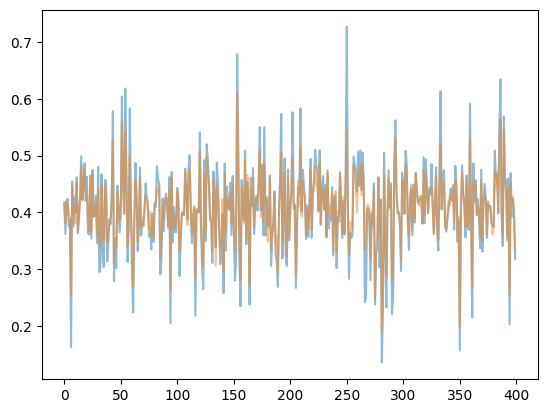

In [233]:

pyplot.plot(zscored_t[:,l], alpha=0.5)
pyplot.plot(p.predict(zscored_t[:,:l]), alpha=0.5)

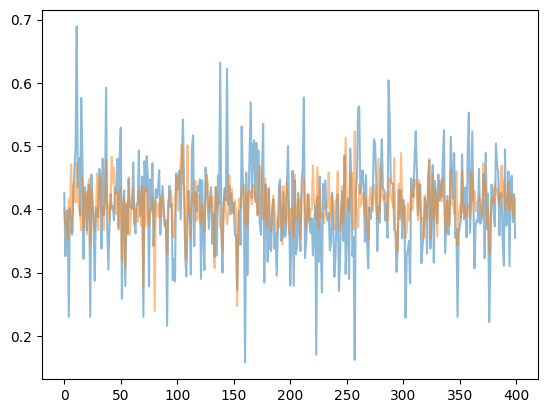

In [234]:

pyplot.plot(zscored_x[:,l], alpha=0.5)
pyplot.plot(p.predict(zscored_x[:,:l]), alpha=0.5)

In [235]:
p.score(zscored_x[:,:l], zscored_x[:,l])

0.19893180527717813

In [236]:
p.score(zscored_t[:,:l], zscored_t[:,l])

0.8840519835648638

In [237]:
numpy.corrcoef(p.predict(zscored_x[:,:l]), zscored_x[:,l])

array([[1.        , 0.45249219],
       [0.45249219, 1.        ]])

In [238]:
zscored_t[:10].tolist()

[[-0.7166170796272686,
  -0.30671664226269474,
  -0.2853607850744571,
  -1.1418247680342306,
  -1.1290156425261095,
  -1.140288712486867,
  -1.172008719993244,
  -1.2185702192029206,
  -1.2658582388728825,
  -1.3128186480048911,
  -1.3674864893758014,
  -1.4193489501289132,
  -1.4866817440677722,
  -1.6189607391730043,
  -1.6767252709631586,
  -1.7202512896138513,
  -1.76820415327104,
  -1.7955099257545883,
  -1.839138936766032,
  -1.8394896538132626,
  -1.7955394889454979,
  -1.6873546190502031,
  -1.4013192159925272,
  -2.018794274626141,
  -2.3348144407940845,
  -2.412405870176344,
  -2.365709566610524,
  -2.235151032086111,
  -2.041078586597869,
  -1.8015141767340224,
  -1.5335641120213863,
  -1.2476211736470904,
  -0.9495284138329725,
  -0.6443366798963627,
  -0.3373316212567137,
  -0.03327377905968877,
  0.26249867665768645,
  0.5418486719915703,
  0.7958135483026549,
  1.0147059085475036,
  1.1913465365581724,
  1.3229941330325778,
  1.3682620548175997,
  -0.7869573065365885,
  

In [239]:
model = MarketSampleTransformer()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

C:\Users\sangsiyuan\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [239]:
for epoch in range(200):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(DEVICE), batch_y.to(DEVICE)
        optimizer.zero_grad()
        pred = model(batch_x)
        loss = criterion(pred, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_x.size(0)
    avg_loss = total_loss / len(train_loader.dataset)

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(DEVICE), batch_y.to(DEVICE)
            pred = model(batch_x)
            loss = criterion(pred, batch_y)
            test_loss += loss.item() * batch_x.size(0)
    avg_test_loss = test_loss / len(test_loader.dataset)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_loss:.6f} | Test Loss: {avg_test_loss:.6f}")